# HOMEWORK 5: TEXT CLASSIFICATION
In this homework, you will create models to classify texts from TRUE call-center. There are two classification tasks:
1. Action Classification: Identify which action the customer would like to take (e.g. enquire, report, cancle)
2. Object Classification: Identify which object the customer is referring to (e.g. payment, truemoney, internet, roaming) 

In this homework, you are asked to do the following tasks:
1. Data Cleaning
2. Preprocessing data for keras
3. Build and evaluate a model for "action" classification
4. Build and evaluate a model for "object" classification
5. Build and evaluate a multi-task model that does both "action" and "object" classifications in one-go 


Note: we have removed phone numbers from the dataset for privacy purposes. 

In [148]:
!wget --no-check-certificate https://www.dropbox.com/s/37u83g55p19kvrl/clean-phone-data-for-students.csv

--2021-02-27 18:45:48--  https://www.dropbox.com/s/37u83g55p19kvrl/clean-phone-data-for-students.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/37u83g55p19kvrl/clean-phone-data-for-students.csv [following]
--2021-02-27 18:45:48--  https://www.dropbox.com/s/raw/37u83g55p19kvrl/clean-phone-data-for-students.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6040348e4000db285c8f9f2970.dl.dropboxusercontent.com/cd/0/inline/BJvYfmyMm0nADjJdW8J5FV-hPIHOt1ynPBWNrqfFQoLir0Fl3muSxY2pUbHAxDKlC2uQdD4zvZNbSZuFXCi5IKWsKg5wPfLXrWTYdlCVCrYvug/file# [following]
--2021-02-27 18:45:48--  https://uc6040348e4000db285c8f9f2970.dl.dropboxusercontent.com/cd/0/inline/BJvYfmyMm0nADjJdW8J5FV-hPIHOt1ynPBWNrqfFQoLir0Fl3muSxY2pUbHAxDKlC2uQd

## Import Libs

In [149]:
%matplotlib inline
import pandas
import sklearn
import numpy as np
from IPython.display import display

import matplotlib.pyplot as plt

## Loading data
First, we load the data from disk into a Dataframe.

A Dataframe is essentially a table, or 2D-array/Matrix with a name for each column.

In [150]:
data_df = pandas.read_csv('clean-phone-data-for-students.csv')

Let's preview the data.

In [151]:
# Show the top 5 rows
display(data_df.head())
# Summarize the data
data_df.describe()

,Sentence Utterance,Action,Object
0,<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counte...,enquire,payment
1,internet ยังความเร็วอยุ่เท่าไหร ครับ,enquire,package
2,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้...,report,suspend
3,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อ...,enquire,internet
4,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโ...,report,phone_issues


,Sentence Utterance,Action,Object
count,16175,16175,16175
unique,13389,10,33
top,บริการอื่นๆ,enquire,service
freq,97,10377,2525


## Data cleaning

We call the DataFrame.describe() again.
Notice that there are 33 unique labels/classes for object and 10 unique labels for action that the model will try to predict.
But there are unwanted duplications e.g. Idd,idd,lotalty_card,Lotalty_card

Also note that, there are 13389 unqiue sentence utterances from 16175 utterances. You have to clean that too!

## #TODO 1: 
You will have to remove unwanted label duplications as well as duplications in text inputs. 
Also, you will have to trim out unwanted whitespaces from the text inputs. 
This shouldn't be too hard, as you have already seen it in the demo.



In [152]:
display(data_df.describe())
display(data_df.Object.unique())
display(data_df.Action.unique())

,Sentence Utterance,Action,Object
count,16175,16175,16175
unique,13389,10,33
top,บริการอื่นๆ,enquire,service
freq,97,10377,2525


array(['payment', 'package', 'suspend', 'internet', 'phone_issues',
       'service', 'nonTrueMove', 'balance', 'detail', 'bill', 'credit',
       'promotion', 'mobile_setting', 'iservice', 'roaming', 'truemoney',
       'information', 'lost_stolen', 'balance_minutes', 'idd',
       'TrueMoney', 'garbage', 'Payment', 'IDD', 'ringtone', 'Idd',
       'rate', 'loyalty_card', 'contact', 'officer', 'Balance', 'Service',
       'Loyalty_card'], dtype=object)

array(['enquire', 'report', 'cancel', 'Enquire', 'buy', 'activate',
       'request', 'Report', 'garbage', 'change'], dtype=object)

In [155]:
data_df = data_df[["Sentence Utterance", "Object","Action"]]

In [156]:
# TODO1: Data cleaning

data_df.columns = ['input', 'raw_label', 'action_label']
data_df['clean_label'] = data_df['raw_label'].apply(lambda x: x.strip().lower())
data_df['action_label'] = data_df['action_label'].apply(lambda x: x.strip().lower())
data_df['input'] = data_df['input'].apply(lambda x: x.strip())
data_df = data_df[["input", "clean_label", 'action_label']]
data_df.describe()
# data_df = data_df.drop_duplicates(subset=['clean_label'])

,input,clean_label,action_label
count,16175,16175,16175
unique,13367,26,8
top,บริการอื่นๆ,service,enquire
freq,97,2528,10484


In [157]:
data_df = data_df.drop_duplicates(subset=['input'])

In [158]:
data_df.head()

,input,clean_label,action_label
0,<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counter...,payment,enquire
1,internet ยังความเร็วอยุ่เท่าไหร ครับ,package,enquire
2,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ,suspend,report
3,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อง...,internet,enquire
4,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโท...,phone_issues,report


## #TODO 2: Preprocessing data for Keras
You will be using Tensorflow 2 keras in this assignment. Please show us how you prepare your data for keras.
Don't forget to split data into train and test sets (+ validation set if you want)

In [159]:
from sklearn import preprocessing
le_c = preprocessing.LabelEncoder()
le_c.fit(data_df.clean_label)
data_df['clean_label_e'] = le.transform(data_df['clean_label'].tolist())

le_a = preprocessing.LabelEncoder()
le_a.fit(data_df.action_label)
data_df['action_label_e'] = le_a.transform(data_df['action_label'].tolist())
# le.transform(["tokyo", "tokyo", "paris"])
# print(list(le.inverse_transform([2, 2, 1])))

In [160]:
data_df.head()

,input,clean_label,action_label,clean_label_e,action_label_e
0,<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counter...,payment,enquire,17,4
1,internet ยังความเร็วอยุ่เท่าไหร ครับ,package,enquire,16,4
2,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ,suspend,report,24,6
3,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อง...,internet,enquire,9,4
4,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโท...,phone_issues,report,18,6


In [161]:
!pip install pythainlp

In [162]:
from pythainlp.tokenize import word_tokenize
data_df['tokenized_input'] = data_df.input.apply(lambda x: word_tokenize(x, engine='newmm'))

In [163]:
all_words = set()
for k in data_df.tokenized_input.to_list():
  all_words = all_words|set(k)

le_word = preprocessing.LabelEncoder()
le_word.fit(['UNK']+list(all_words))
data_df['input_e'] = data_df['tokenized_input'].apply(lambda x: le_word.transform(x))

In [164]:

from tensorflow import keras
from tensorflow.keras import preprocessing as pre
X  = pre.sequence.pad_sequences(
    data_df.input_e.tolist(), maxlen=130, dtype='int32', padding='pre',
    truncating='pre', value=0.0
)
y_action = keras.utils.to_categorical(
    data_df.action_label_e, num_classes=None, dtype='float32'
)
y_object = keras.utils.to_categorical(
    data_df.clean_label_e, num_classes=None, dtype='float32'
)

from sklearn.model_selection import train_test_split

X_train, X_test,y_action_train,y_action_test,y_object_train,y_object_test = train_test_split(X,y_action,y_object,test_size=0.3,random_state=5)

X_val, X_test, y_action_val, y_action_test, y_object_val, y_object_test = train_test_split(X_test,y_action_test,y_object_test,test_size=0.33,random_state=5)

In [165]:
len(X_val) + len(X_test) + len(X_train) == len(X)

True

In [166]:
len(all_words)

4163

In [ ]:
#TODO 3: Build and evaluate a model for "action" classification

## #TODO 3: Build and evaluate a model for "action" classification


In [167]:
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
input_layers = layers.Input((130,))
x = layers.Embedding(len(all_words)+1, 128, input_length=130)(input_layers)
x = layers.LSTM(128)(x)
x = layers.Dense(128, activation = 'relu')(x)
out_action = layers.Dense(8, activation = 'softmax')(x)

model_action = Model(inputs=input_layers , outputs=out_action)
model_action.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])

In [168]:
K.clear_session()
his_action = model_action.fit(X_train, y_action_train, epochs=10, batch_size=32, verbose=1,
        validation_data = (X_val,y_action_val) )

Epoch 1/10
293/293 [==============================] - 6s 17ms/step - loss: 1.2797 - acc: 0.6492 - val_loss: 0.5630 - val_acc: 0.8284
Epoch 2/10
293/293 [==============================] - 4s 15ms/step - loss: 0.4906 - acc: 0.8445 - val_loss: 0.4461 - val_acc: 0.8560
Epoch 3/10
293/293 [==============================] - 4s 14ms/step - loss: 0.3225 - acc: 0.8918 - val_loss: 0.4360 - val_acc: 0.8563
Epoch 4/10
293/293 [==============================] - 4s 14ms/step - loss: 0.2529 - acc: 0.9121 - val_loss: 0.4356 - val_acc: 0.8630
Epoch 5/10
293/293 [==============================] - 4s 14ms/step - loss: 0.2206 - acc: 0.9289 - val_loss: 0.4652 - val_acc: 0.8478
Epoch 6/10
293/293 [==============================] - 4s 14ms/step - loss: 0.1861 - acc: 0.9354 - val_loss: 0.4884 - val_acc: 0.8604
Epoch 7/10
293/293 [==============================] - 4s 14ms/step - loss: 0.1780 - acc: 0.9402 - val_loss: 0.5155 - val_acc: 0.8526
Epoch 8/10
293/293 [==============================] - 4s 14ms/step - 

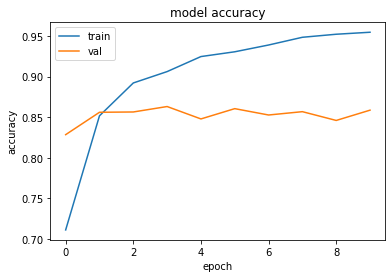

In [169]:
import keras
from matplotlib import pyplot as plt

plt.plot(his_action.history['acc'])
plt.plot(his_action.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [184]:
model_action.evaluate(X_test,y_action_test, batch_size=32)

42/42 [==============================] - 0s 6ms/step - loss: 0.6921 - acc: 0.8384


[0.6921424269676208, 0.8383685946464539]

Confusion matrix, without normalization
Normalized confusion matrix


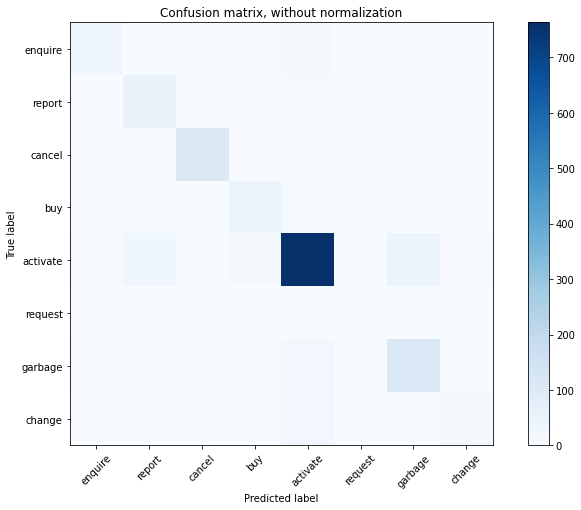

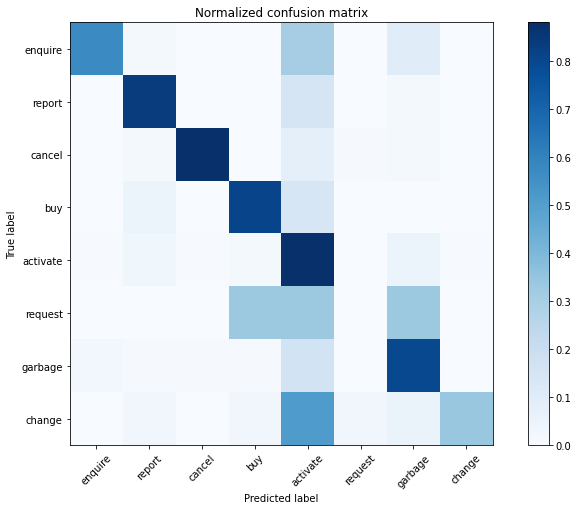

In [176]:
import itertools
from sklearn.metrics import confusion_matrix
#Reference: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
y_pred = model_action.predict(X_test)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
cnf_matrix = confusion_matrix(np.argmax(y_action_test,axis=1), np.argmax(y_pred,axis=1))
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,7))
plot_confusion_matrix(cnf_matrix, classes=data_df.action_label.unique(),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,7))
plot_confusion_matrix(cnf_matrix, classes=data_df.action_label.unique(), normalize=True,
                      title='Normalized confusion matrix')

plt.show()


## #TODO 4: Build and evaluate a model for "object" classification



In [179]:
#TODO 4: Build and evaluate a model for "object" classification
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
input_layers = layers.Input((130,))
x = layers.Embedding(len(all_words)+1, 128, input_length=130)(input_layers)
x = layers.LSTM(128)(x)
x = layers.Dense(128, activation = 'relu')(x)
out_object = layers.Dense(26, activation = 'softmax')(x)

model_object = Model(inputs=input_layers , outputs=out_object)
model_object.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])

K.clear_session()
his_object = model_object.fit(X_train, y_object_train, epochs=10, batch_size=32, verbose=1,
        validation_data = (X_val,y_object_val) )

Epoch 1/10
293/293 [==============================] - 8s 16ms/step - loss: 2.5910 - acc: 0.2226 - val_loss: 1.5148 - val_acc: 0.5359
Epoch 2/10
293/293 [==============================] - 4s 13ms/step - loss: 1.3289 - acc: 0.5926 - val_loss: 1.1539 - val_acc: 0.6598
Epoch 3/10
293/293 [==============================] - 4s 13ms/step - loss: 0.9022 - acc: 0.7297 - val_loss: 1.0371 - val_acc: 0.6878
Epoch 4/10
293/293 [==============================] - 4s 13ms/step - loss: 0.7017 - acc: 0.7895 - val_loss: 0.9954 - val_acc: 0.7127
Epoch 5/10
293/293 [==============================] - 4s 14ms/step - loss: 0.5916 - acc: 0.8182 - val_loss: 1.0155 - val_acc: 0.7157
Epoch 6/10
293/293 [==============================] - 4s 13ms/step - loss: 0.5171 - acc: 0.8447 - val_loss: 1.0449 - val_acc: 0.7194
Epoch 7/10
293/293 [==============================] - 4s 13ms/step - loss: 0.4170 - acc: 0.8740 - val_loss: 1.0722 - val_acc: 0.7164
Epoch 8/10
293/293 [==============================] - 4s 13ms/step - 

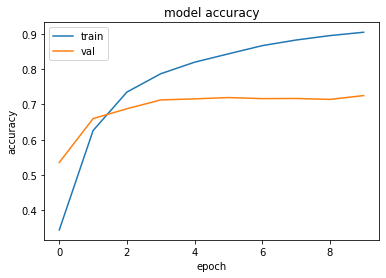

In [180]:
import keras
from matplotlib import pyplot as plt

plt.plot(his_object.history['acc'])
plt.plot(his_object.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [182]:
model_object.evaluate(X_test,y_object_test, batch_size=32)

42/42 [==============================] - 0s 6ms/step - loss: 1.2226 - acc: 0.7024


[1.2226386070251465, 0.7024168968200684]

Confusion matrix, without normalization
Normalized confusion matrix


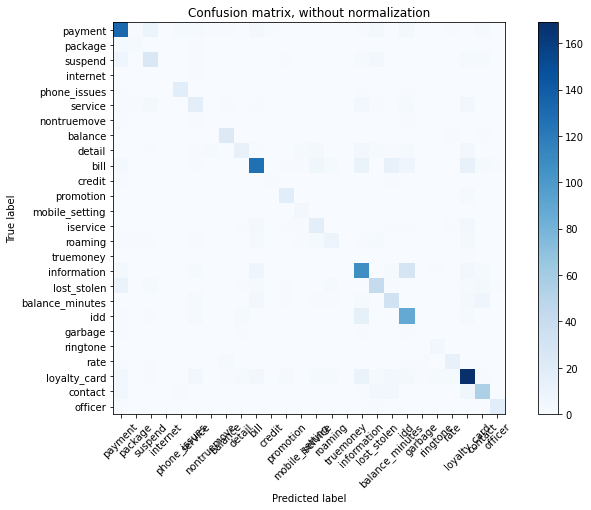

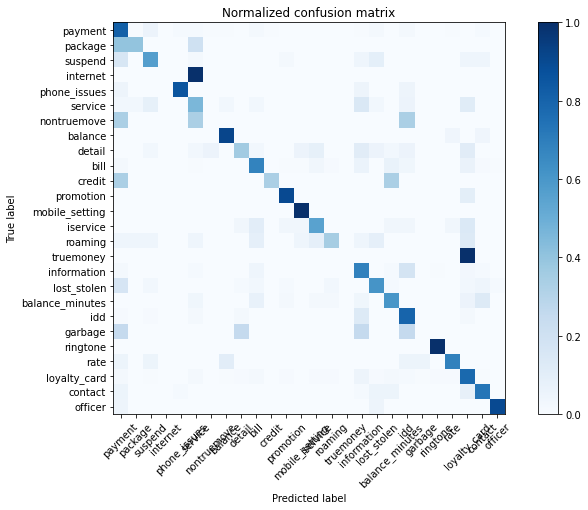

In [181]:
import itertools
from sklearn.metrics import confusion_matrix
#Reference: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
y_pred_object = model_object.predict(X_test)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
cnf_matrix = confusion_matrix(np.argmax(y_object_test,axis=1), np.argmax(y_pred_object,axis=1))
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,7))
plot_confusion_matrix(cnf_matrix, classes=data_df.clean_label.unique(),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,7))
plot_confusion_matrix(cnf_matrix, classes=data_df.clean_label.unique(), normalize=True,
                      title='Normalized confusion matrix')

plt.show()


## #TODO 5: Build and evaluate a multi-task model that does both "action" and "object" classifications in one-go 

This can be a bit tricky, if you are not familiar with the Keras functional API. PLEASE READ these webpages(https://www.tensorflow.org/guide/keras/functional, https://keras.io/getting-started/functional-api-guide/) before you start this task.   

Your model will have 2 separate output layers one for action classification task and another for object classification task. 

This is a rough sketch of what your model might look like:
![image](https://raw.githubusercontent.com/ekapolc/nlp_course/master/HW5/multitask_sketch.png)

In [192]:
#TODO 5: Build and evaluate a multi-task model that does both "action" and "object" classifications in one-go
input_layers = layers.Input((130,))
x = layers.Embedding(len(all_words)+1, 128, input_length=130)(input_layers)
x = layers.LSTM(128)(x)
x = layers.Dense(128, activation = 'relu')(x)
out_object = layers.Dense(26, activation = 'softmax',name='out_object')(x)
out_action = layers.Dense(8, activation = 'softmax', name= 'out_action')(x)



model_both = Model(inputs=input_layers, outputs=[out_action, out_object])
model_both.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])

In [193]:
model_both.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 130)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 130, 128)     532992      input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 128)          131584      embedding_1[0][0]                
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 128)          16512       lstm_1[0][0]                     
____________________________________________________________________________________________

In [194]:
his_both = model_both.fit(X_train, [y_action_train,y_object_train], epochs=10, batch_size=32, verbose=1,
        validation_data = (X_val,[y_action_val,y_object_val]) )

Epoch 1/10
293/293 [==============================] - 7s 18ms/step - loss: 3.9737 - out_action_loss: 1.2940 - out_object_loss: 2.6797 - out_action_acc: 0.6417 - out_object_acc: 0.1902 - val_loss: 2.2829 - val_out_action_loss: 0.6203 - val_out_object_loss: 1.6626 - val_out_action_acc: 0.7961 - val_out_object_acc: 0.5035
Epoch 2/10
293/293 [==============================] - 4s 15ms/step - loss: 2.0797 - out_action_loss: 0.5616 - out_object_loss: 1.5181 - out_action_acc: 0.8169 - out_object_acc: 0.5504 - val_loss: 1.7473 - val_out_action_loss: 0.4867 - val_out_object_loss: 1.2606 - val_out_action_acc: 0.8411 - val_out_object_acc: 0.6290
Epoch 3/10
293/293 [==============================] - 4s 15ms/step - loss: 1.4194 - out_action_loss: 0.3801 - out_object_loss: 1.0393 - out_action_acc: 0.8736 - out_object_acc: 0.6906 - val_loss: 1.4404 - val_out_action_loss: 0.4142 - val_out_object_loss: 1.0261 - val_out_action_acc: 0.8638 - val_out_object_acc: 0.6911
Epoch 4/10
293/293 [=================

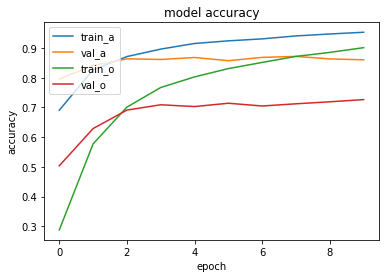

In [197]:
import keras
from matplotlib import pyplot as plt

plt.plot(his_both.history['out_action_acc'])
plt.plot(his_both.history['val_out_action_acc'])
plt.plot(his_both.history['out_object_acc'])
plt.plot(his_both.history['val_out_object_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_a', 'val_a','train_o','val_o'], loc='upper left')
plt.show()

In [198]:
model_both.evaluate(X_test,[y_action_test,y_object_test], batch_size=32)

42/42 [==============================] - 0s 7ms/step - loss: 1.7693 - out_action_loss: 0.5754 - out_object_loss: 1.1939 - out_action_acc: 0.8565 - out_object_acc: 0.7213


[1.7693276405334473,
 0.5754289031028748,
 1.193899154663086,
 0.8564954400062561,
 0.7212991118431091]

Confusion matrix, without normalization
Normalized confusion matrix
Confusion matrix, without normalization
Normalized confusion matrix


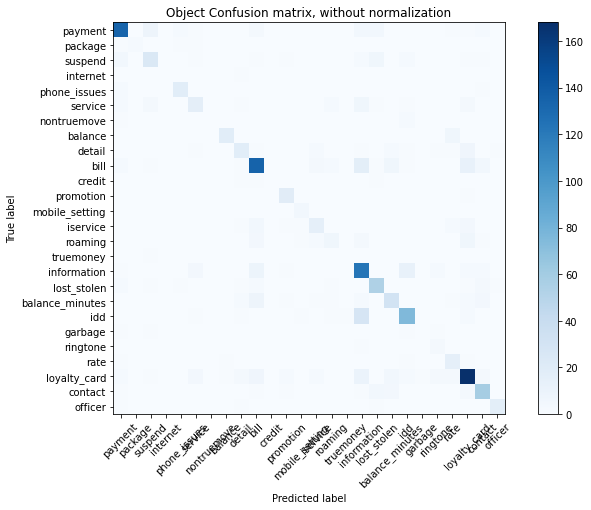

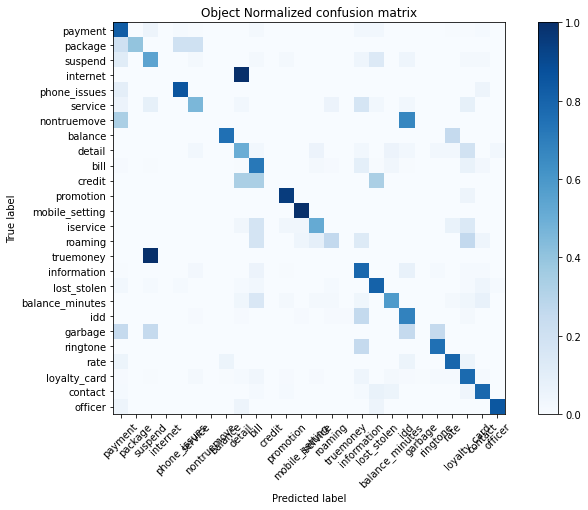

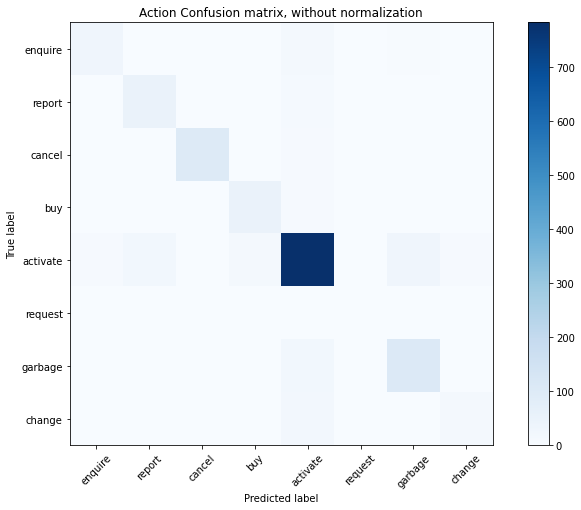

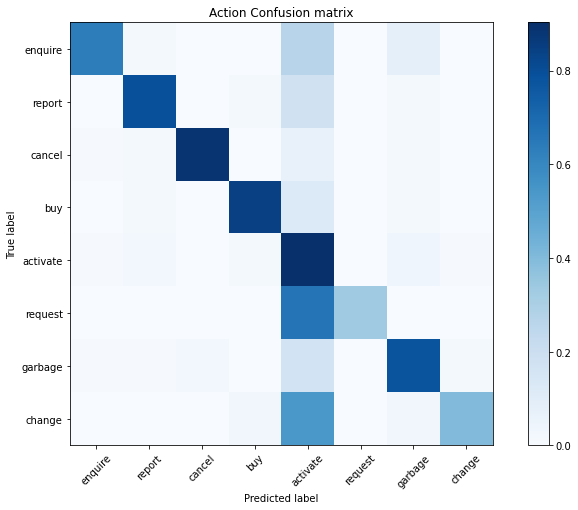

In [201]:
import itertools
from sklearn.metrics import confusion_matrix
#Reference: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
y_pred_action, y_pred_object = model_both.predict(X_test)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
cnf_matrix_object = confusion_matrix(np.argmax(y_object_test,axis=1), np.argmax(y_pred_object,axis=1))

cnf_matrix_action = confusion_matrix(np.argmax(y_action_test,axis=1), np.argmax(y_pred_action,axis=1))
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,7))
plot_confusion_matrix(cnf_matrix_object, classes=data_df.clean_label.unique(),
                      title='Object Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,7))
plot_confusion_matrix(cnf_matrix_object, classes=data_df.clean_label.unique(), normalize=True,
                      title='Object Normalized confusion matrix')

plt.figure(figsize=(10,7))
plot_confusion_matrix(cnf_matrix_action, classes=data_df.action_label.unique(),
                      title='Action Confusion matrix, without normalization')

plt.figure(figsize=(10,7))
plot_confusion_matrix(cnf_matrix_action, classes=data_df.action_label.unique(),normalize=True,
                      title='Action Confusion matrix')
plt.show()